In [1]:
!pip install keras-tuner

     |████████████████████████████████| 129 kB 6.7 MB/s            


In [2]:
import tensorflow as tf
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import os

In [104]:
# 데이터로드
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [53]:
x_train.shape

(50000, 32, 32, 3)

In [54]:
y_train.shape

(50000, 1)

In [55]:
import numpy as np

np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [62]:
wrong_idx = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 
         5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]

### 데이터 및 라벨링 확인

In [ ]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [90]:
from tensorflow.keras.datasets import cifar10

# Load the CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

print("Training data shape:", x_train_full.shape)
print("Training labels shape:", y_train_full.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [ ]:
y_train_full

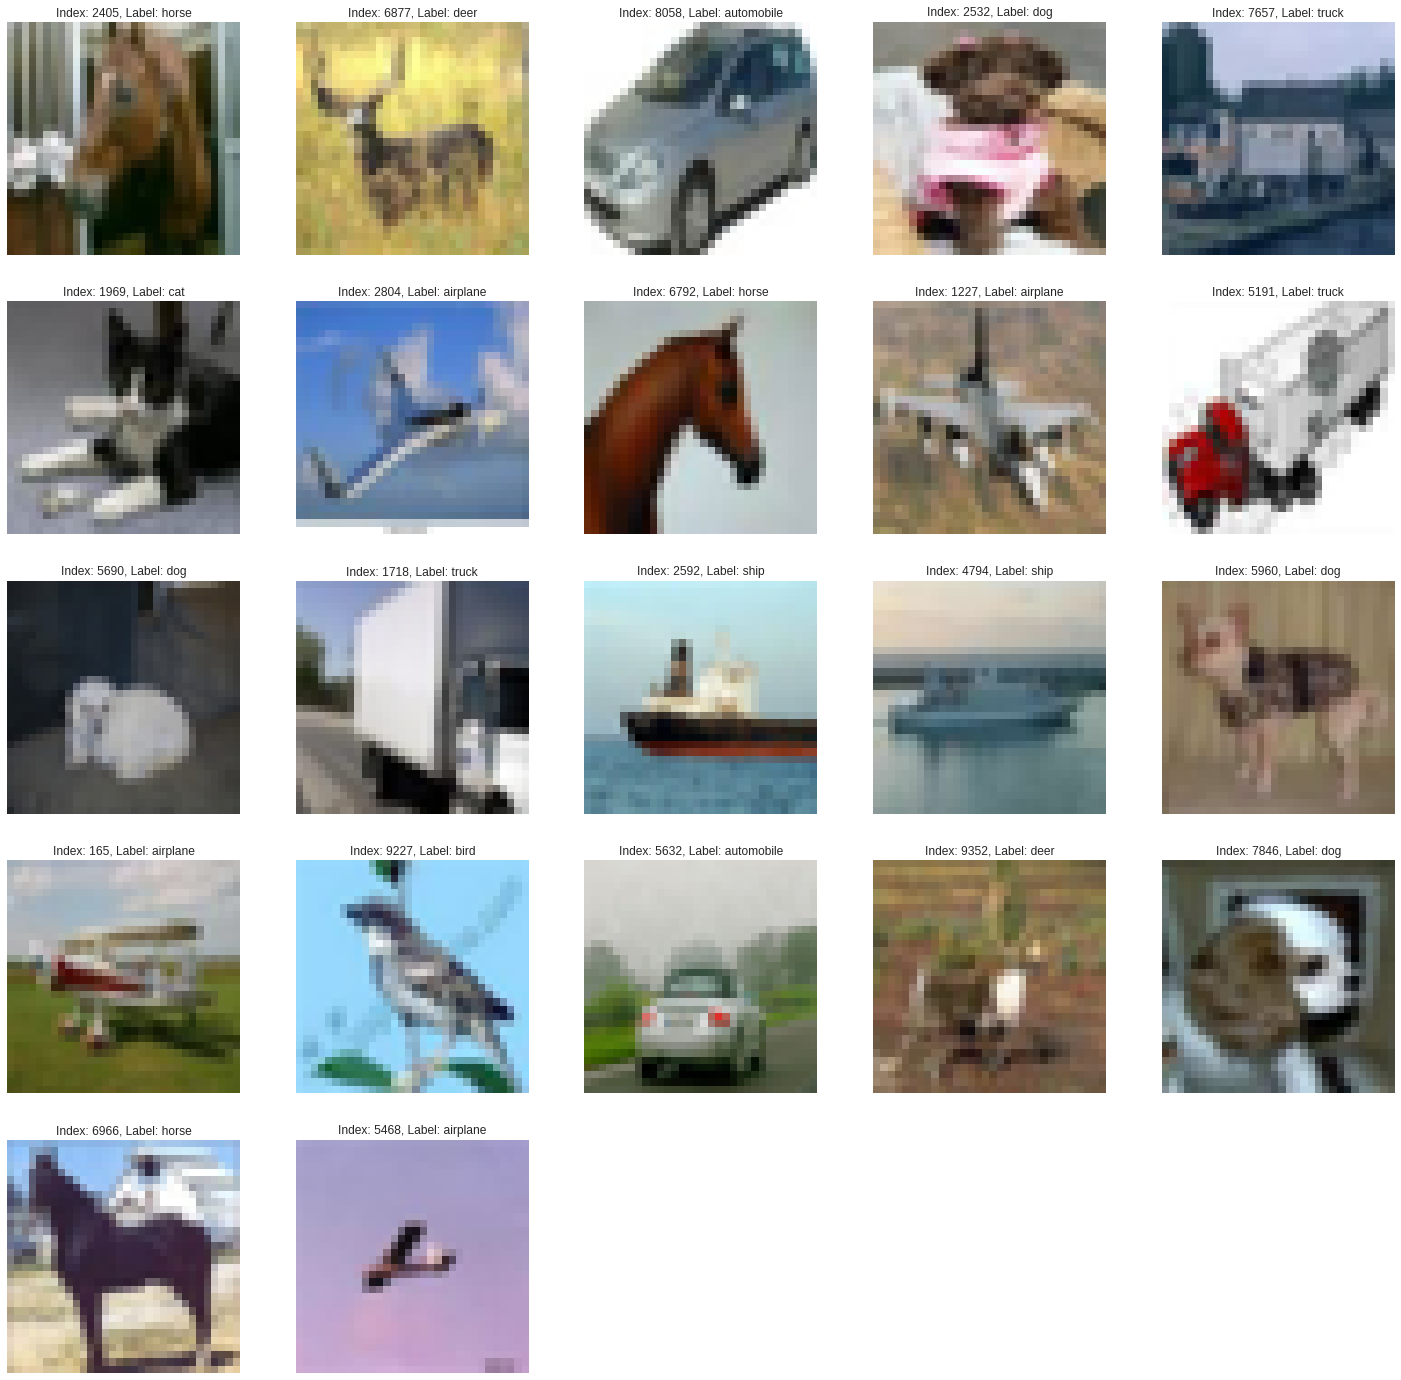

In [113]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(25, 30))
for i, idx in enumerate(wrong_idx):
  img = x_train_full[idx, :]
  label = y_train_full[idx, 0]

  plt.subplot(6, 5, i+1)
  plt.axis('off')
  plt.title(f'Index: {idx}, Label: {class_names[label]}')
  plt.imshow(img)

1️⃣ Data Centric AI 맛보기
- wrong_idx 라고 알려준 데이터들을 보니 전부 라벨링이 잘 되어 있음
- 고정된 모델과 이전 mnist 실습에서 썼던 모델 둘 다 실험

In [105]:
# lable => categorical 변환
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [20]:
np.unique(y_train)

array([0., 1.], dtype=float32)

In [106]:
# train, validation split
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)
print(X_train.shape)

(40000, 32, 32, 3)


In [107]:
X_val.shape, y_val.shape

((10000, 32, 32, 3), (10000, 10))

In [59]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)


        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

In [60]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = X_train.shape[1:], name = 'inputs'))
    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
              model.add(tf.keras.layers.Conv2D(hp.Int(
                  'units_{i}'.format(i=i), min_value=32, max_value=128, step=5), (3,3),activation='relu'))
    model.add(tf.keras.layers.Flatten())
    for i in range(hp.Int('n_connections', 1, 3)):
        model.add(tf.keras.layers.Dense(hp.Choice(f'n_nodes',
                                  values=[32, 64, 128, 256]), activation = 'relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax', name = 'outputs'))
    model.compile(optimizer = 'adam',loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

2️⃣ 주어진 문제 모델 만들기

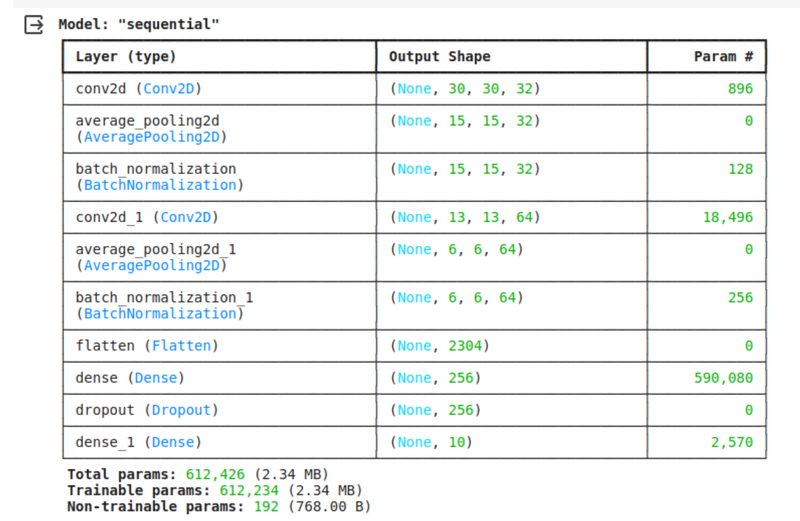

In [41]:
input_layer = tf.keras.layers.Input(shape=(32, 32, 3))
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='valid')(input_layer)
x=tf.keras.layers.AveragePooling2D(pool_size=(2, 2),strides=(2, 2), padding="same")(x)
x=tf.keras.layers.BatchNormalization()(x)

x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='valid')(x)
x=tf.keras.layers.AveragePooling2D(pool_size=(2, 2),strides=(2, 2), padding="valid")(x)
x=tf.keras.layers.BatchNormalization()(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(256, activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x)
out_layer=tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d_25 (Averag (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_26 (Averag (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 6, 6, 64)          256 

In [108]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        # model_fix
        model = Modelfix(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)

        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

def Modelfix(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=X_train.shape[1:], name='inputs'))
    
    # 고정된 모델 구조 사용
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='valid'))
    model.add(tf.keras.layers.AveragePooling2D((2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.AveragePooling2D((2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax', name='outputs'))
    
    # 하이퍼파라미터 튜닝할 옵티마이저와 학습률 설정
    optimizer_name = hp.Choice('optimizer', ['Adam', 'rmsprop', 'SGD'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer = getattr(tf.keras.optimizers, optimizer_name)(learning_rate=learning_rate)
    model.compile(
                  optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                  )
    return model

my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=Modelfix,
    overwrite=True,
    project_name='my_keras_tuner')

3️⃣ KerasTuner로 하이퍼파라미터 튜닝

In [109]:
my_keras_tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

Trial 10 Complete [00h 00m 23s]
accuracy: 0.6481000185012817

Best accuracy So Far: 0.6947000026702881
Total elapsed time: 00h 02m 54s


In [110]:
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = Modelfix(best_hps)
model.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_262 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d_99 (Averag (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_263 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_100 (Avera (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_98 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_77 (Flatten)         (None, 2304)            

In [111]:
model.fit(X_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6669 - accuracy: 0.4553
Epoch 2/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.1629 - accuracy: 0.5889
Epoch 3/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.0101 - accuracy: 0.6464
Epoch 4/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9081 - accuracy: 0.6798
Epoch 5/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8161 - accuracy: 0.7139
Epoch 6/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7379 - accuracy: 0.7414
Epoch 7/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6800 - accuracy: 0.7577
Epoch 8/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6170 - accuracy: 0.7840
Epoch 9/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5600 - accuracy: 0.8026
Epoch 10/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.527

In [112]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.0354 - accuracy: 0.7312


[1.0353519916534424, 0.7311999797821045]

#### 번외. 모델 고정해놓지 않고

In [61]:
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')

# 10 분 소요
my_keras_tuner.search(
    X_train, y_train, validation_data=(X_val, y_val), epochs=3)

Trial 10 Complete [00h 00m 46s]
accuracy: 0.09549999982118607

Best accuracy So Far: 0.586899995803833
Total elapsed time: 00h 08m 05s


In [63]:
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_185 (Conv2D)          (None, 30, 30, 102)       2856      
_________________________________________________________________
conv2d_186 (Conv2D)          (None, 28, 28, 42)        38598     
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 26, 26, 67)        25393     
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 24, 24, 37)        22348     
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 22, 22, 52)        17368     
_________________________________________________________________
flatten_41 (Flatten)         (None, 25168)             0         
_________________________________________________________________
dense_66 (Dense)             (None, 256)             

In [64]:
model.fit(X_train, y_train, batch_size=32, epochs = 5)

Epoch 1/5
1250/1250 [==============================] - 11s 9ms/step - loss: 1.8192 - accuracy: 0.3893
Epoch 2/5
1250/1250 [==============================] - 11s 9ms/step - loss: 1.2366 - accuracy: 0.5668
Epoch 3/5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9439 - accuracy: 0.6704
Epoch 4/5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.6159 - accuracy: 0.7840
Epoch 5/5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.3583 - accuracy: 0.8754


In [66]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.8893 - accuracy: 0.5542


[1.889277696609497, 0.5541999936103821]

## 회고

1. 모델 해석

- Conv2D, AveragePooling2D : 공간적인 특징을 추출, 여러 층을 통해 점진적으로 데이터 추상화
- BatchNormalization : 각 층의 입력을 정규화하여 학습 과정을 안정화, Dropout: 과적합 방지.
- 분류를 위한 Dense 층은 높은 차원의 특성 공간을 만들어 분류 성능 증대

2. 배운 점
- 모델 구조 중요성: 고정된 모델 구조가 데이터와 잘 맞을 때 성능이 크게 향상될 수 있음을 경험했습니다. 적절한 계층 구성과 하이퍼파라미터가 모델 성능에 큰 영향을 줄 수 있음을 보았습니다.
- 하이퍼파라미터 튜닝: 다양한 하이퍼파라미터를 조정하는 것만으로도 성능에 큰 차이를 만들 수 있음을 배웠습니다. 특히, 학습률과 옵티마이저의 선택이 중요하다는 것을 확인했습니다.

3. 발전시킬 점
- 데이터 전처리 및 확장: 입력 데이터의 다양성을 높이고, 전처리 과정을 개선하여 모델이 더 일반화된 패턴 학습
- 더 많은 모델 구조 시험, 하이퍼파라미터 최적화 확장
